# Quantum Adversarial Machine Learning

## Implementation of Lu et al. (2020)

**Paper:** "Quantum Adversarial Machine Learning"  
**Authors:** Sirui Lu, Lu-Ming Duan, Dong-Ling Deng  
**Published:** Physical Review Research 2, 033212 (2020)  
**arXiv:** [2001.00030](https://arxiv.org/abs/2001.00030)

---

This notebook provides:
1. **Background** on the paper and quantum adversarial ML
2. **Code walkthrough** of the implementation
3. **Running experiments** with examples
4. **Reproducing figures** from the paper
5. **Extended analysis** comparing amplitude vs angle encoding

## 1. Paper Overview

### Key Question

Are quantum machine learning models vulnerable to adversarial attacks, just like classical neural networks?

### Main Findings

1. **Yes, quantum classifiers are vulnerable** to adversarial perturbations
2. **Adversarial perturbations are much more effective** than random noise (key insight!)
3. **Black-box attacks transfer** from classical surrogates to quantum models
4. **Adversarial training helps** but doesn't fully solve the problem

### Architecture

The paper uses a hybrid classical-quantum classifier:

```
Classical Input (image) → Amplitude Encoding → Variational Quantum Circuit → Measurement → Classification
```

**Amplitude Encoding:** Classical data $x$ is encoded into quantum state amplitudes:
$$|\psi_x\rangle = \sum_i x_i |i\rangle$$

**Variational Circuit:** Parameterized quantum gates trained via gradient descent

### Attack Methods

- **FGSM** (Fast Gradient Sign Method): Single-step attack
- **BIM** (Basic Iterative Method): Multi-step iterative attack  
- **PGD** (Projected Gradient Descent): BIM with random initialization
- **MIM** (Momentum Iterative Method): BIM with momentum

### Encoding Dimensionality (Implementation Detail)

The classical encoder must output the right dimension for quantum encoding:

| Encoding | Output Dimension | Formula | MNIST config (13 modes, 3 photons) |
|----------|-----------------|---------|------------------------------------|
| **Amplitude** | Fock space dim | C(n_modes, n_photons) | C(13,3) = 286 states |
| **Angle** | Number of modes | n_modes | 13 phase shifters |

For faithful paper reproduction, we need **C(n_modes, n_photons) >= input_dim** (256 for MNIST).  
With 13 modes and 3 photons: C(13,3) = 286 >= 256 ✓

For **amplitude encoding**, data maps to Fock basis state amplitudes:  
$|\\psi\\rangle = \\sum_i x_i |i\\rangle$ where $|i\\rangle$ are the 286 Fock states.

For **angle encoding**, data maps to phase shifter rotations:  
$x_i \\rightarrow PS(\\phi = x_i)$ on each of the 13 modes.

## 2. Setup

First, let's set up the environment and imports.

In [1]:
# Add parent directory to path for imports
import sys
sys.path.insert(0, '..')

# Standard imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Our implementation
from lib.models import create_model
from lib.datasets import create_dataloaders
from lib.training import train_model
from lib.attacks import (
    bim_attack, fgsm_attack,
    evaluate_attack_success, compare_noise_vs_adversarial
)
from lib.visualization import (
    plot_training_curves, plot_adversarial_examples,
    plot_robustness_comparison, plot_noise_vs_adversarial
)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## 3. Code Structure

The implementation is organized as follows:

```
quantum_adversarial_ml/
├── lib/
│   ├── circuits.py      # Quantum circuits (MerLin photonic + PennyLane)
│   ├── models.py        # Model architectures (hybrid classical-quantum)
│   ├── datasets.py      # MNIST, Ising, Topological datasets
│   ├── training.py      # Training loops
│   ├── attacks.py       # FGSM, BIM, PGD, MIM attacks
│   ├── defense.py       # Adversarial training
│   ├── visualization.py # Plotting functions
│   └── runner.py        # Experiment orchestration
├── configs/             # JSON configuration files
├── scripts/             # Shell scripts to reproduce paper
└── notebooks/           # This notebook
```

### Key Classes

| Class | Description |
|-------|-------------|
| `MerLinAmplitudeClassifier` | Photonic quantum classifier with amplitude encoding |
| `MerLinQuantumClassifier` | Photonic quantum classifier with angle encoding |
| `HybridQuantumClassifier` | Classical encoder + quantum circuit |
| `HybridAmplitudeClassifier` | Classical encoder + amplitude-encoded quantum circuit |

## 4. Training a Quantum Classifier

Let's train a quantum classifier on binary MNIST (digits 1 vs 9).

In [2]:
# Dataset configuration
dataset_config = {
    "digits": [1, 9],      # Binary classification: 1 vs 9
    "image_size": 16,      # Downscale to 16x16
    "normalize": True,
    "batch_size": 256
}

# Create data loaders
train_loader, test_loader = create_dataloaders(
    "mnist_binary", dataset_config, seed=42
)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Training samples: 12691
Test samples: 2144


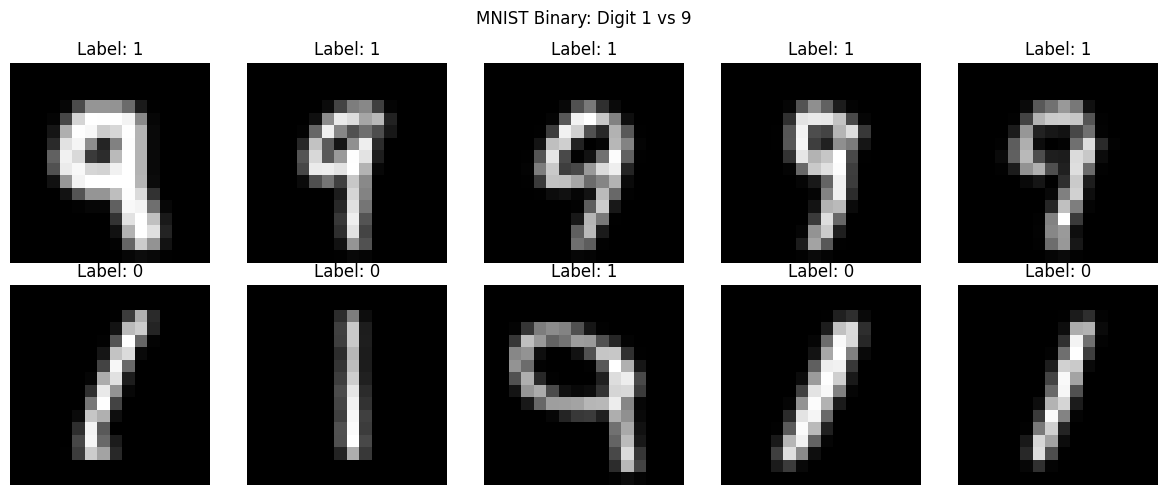

In [3]:
# Visualize some samples
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img = images[i].numpy().reshape(16, 16)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')
plt.suptitle("MNIST Binary: Digit 1 vs 9")
plt.tight_layout()
plt.show()

In [4]:
# Model configuration (amplitude encoding - faithful to Lu et al. 2020)
# For 256-dim input, we need C(n_modes, n_photons) >= 256
# Using 13 modes, 3 photons: C(13,3) = 286 >= 256 ✓
model_config = {
    "type": "amplitude_quantum",  # Amplitude encoding: |ψ⟩ = Σᵢ xᵢ|i⟩
    "input_dim": 256,             # 16x16 = 256 pixels
    "n_outputs": 2,               # Binary classification
    "n_modes": 13,                # Optical modes
    "n_photons": 3,               # Photon number
    "n_layers": 2,               # Quantum circuit depth
    "computation_space": "unbunched"  # C(13,3) = 286 Fock states
}
# No classical compression needed! 256 pixels map directly to 286 Fock states.
# This faithfully reproduces the paper's amplitude encoding approach.

# Create model
model = create_model(model_config).to(device)
print(f"Model: {model.__class__.__name__}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Model: MerLinAmplitudeClassifier
Parameters: 798


In [5]:
# Training configuration
training_config = {
    "epochs": 100,         # Same as configs (use 50 for quick demo)
    "learning_rate": 0.005,
    "optimizer": "adam"
}

# Train the model
print("Training quantum classifier...")
results = train_model(
    model, train_loader, test_loader,
    training_config, device,
    save_path="trained_model.pt"
)

print(f"\nBest accuracy: {results['best_accuracy']:.1%}")

Training quantum classifier...


Loss: 0.0147 | Train: 0.996 | Test: 0.996: 100%|██████████| 100/100 [57:23<00:00, 34.43s/it]  


Best accuracy: 99.6%


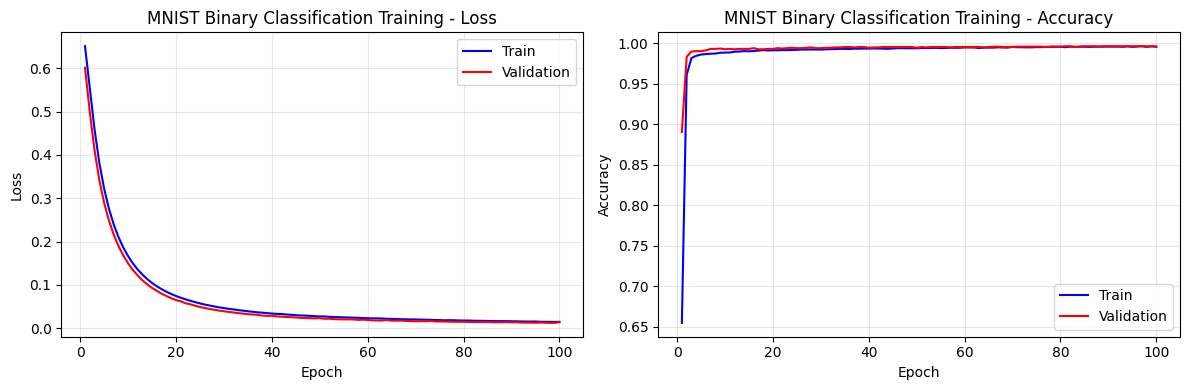

In [6]:
# Plot training curves (reproduces Figure 4-5 style)
plot_training_curves(
    results["history"],
    title="MNIST Binary Classification Training"
)
plt.show()

## 5. Adversarial Attacks

Now let's attack the trained model with adversarial perturbations.

### BIM Attack (Basic Iterative Method)

The BIM attack iteratively applies small perturbations:

$$x^{(t+1)} = \text{Clip}_{x,\epsilon}\left(x^{(t)} + \alpha \cdot \text{sign}(\nabla_x L(x^{(t)}, y))\right)$$

Where:
- $\epsilon$ is the maximum perturbation magnitude
- $\alpha$ is the step size
- $L$ is the loss function

In [7]:
# Attack configuration
epsilon = 0.1    # Maximum perturbation (L∞ norm)
num_iter = 10    # BIM iterations
alpha = 0.01     # Step size

# Get a batch of test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Generate adversarial examples
model.eval()
adv_images = bim_attack(
    model, images, labels,
    epsilon=epsilon, alpha=alpha, num_iter=num_iter
)

# Evaluate
with torch.no_grad():
    clean_preds = model(images).argmax(dim=1)
    adv_preds = model(adv_images).argmax(dim=1)

clean_acc = (clean_preds == labels).float().mean().item()
adv_acc = (adv_preds == labels).float().mean().item()
fooling_rate = (clean_preds != adv_preds).float().mean().item()

print(f"Clean accuracy:       {clean_acc:.1%}")
print(f"Adversarial accuracy: {adv_acc:.1%}")
print(f"Fooling rate:         {fooling_rate:.1%}")
print(f"Accuracy drop:        {(clean_acc - adv_acc)*100:.1f}%")

Clean accuracy:       99.6%
Adversarial accuracy: 0.0%
Fooling rate:         99.6%
Accuracy drop:        99.6%


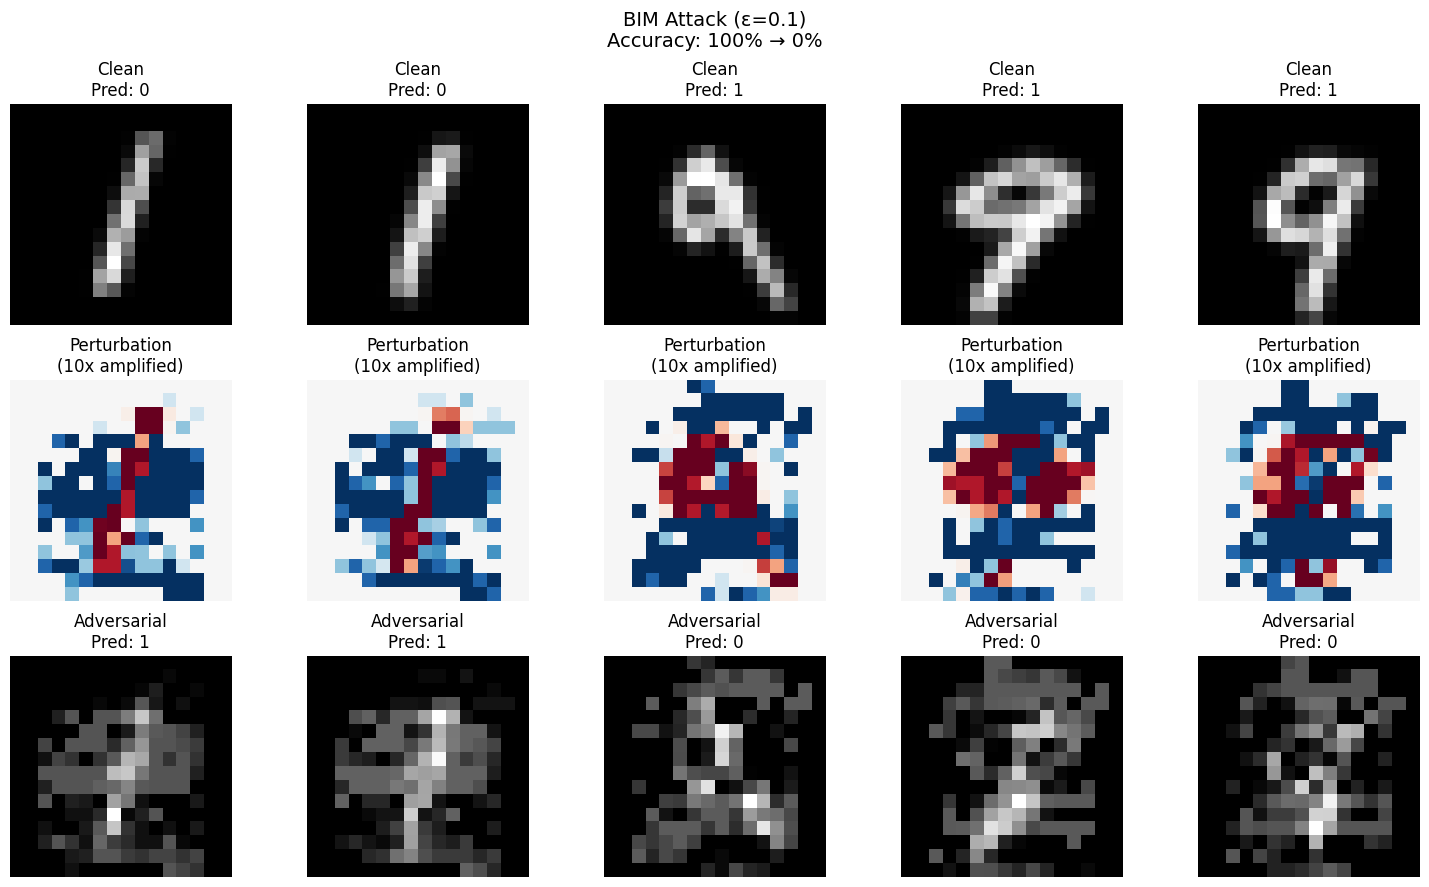

In [8]:
# Visualize adversarial examples (reproduces Figure 6/9)
n_show = 5
fig, axes = plt.subplots(3, n_show, figsize=(15, 9))

for i in range(n_show):
    # Clean image
    clean_img = images[i].cpu().numpy().reshape(16, 16)
    axes[0, i].imshow(clean_img, cmap='gray')
    axes[0, i].set_title(f"Clean\nPred: {clean_preds[i].item()}")
    axes[0, i].axis('off')
    
    # Perturbation (amplified for visibility)
    perturbation = (adv_images[i] - images[i]).cpu().numpy().reshape(16, 16)
    axes[1, i].imshow(perturbation * 10, cmap='RdBu', vmin=-0.5, vmax=0.5)
    axes[1, i].set_title(f"Perturbation\n(10x amplified)")
    axes[1, i].axis('off')
    
    # Adversarial image
    adv_img = adv_images[i].cpu().numpy().reshape(16, 16)
    axes[2, i].imshow(adv_img, cmap='gray')
    axes[2, i].set_title(f"Adversarial\nPred: {adv_preds[i].item()}")
    axes[2, i].axis('off')

axes[0, 0].set_ylabel("Clean", fontsize=12)
axes[1, 0].set_ylabel("Perturbation", fontsize=12)
axes[2, 0].set_ylabel("Adversarial", fontsize=12)

plt.suptitle(f"BIM Attack (ε={epsilon})\nAccuracy: {clean_acc:.0%} → {adv_acc:.0%}", fontsize=14)
plt.tight_layout()
plt.show()

## 6. Figure 7: Robustness vs Epsilon

How does model accuracy change as we increase the perturbation magnitude?

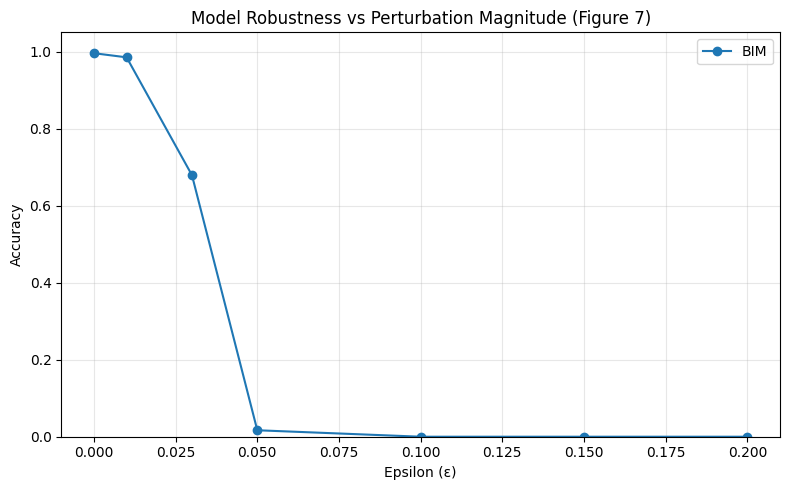

In [9]:
from lib.defense import evaluate_robustness

# Test multiple epsilon values
epsilons = [0.0, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

robustness_results = evaluate_robustness(
    model, test_loader,
    attack_methods=["bim"],
    epsilons=epsilons,
    num_iter=10,
    device=device
)

# Plot results
plot_robustness_comparison(
    robustness_results,
    title="Model Robustness vs Perturbation Magnitude (Figure 7)"
)
plt.show()

## 7. Figure 11: Adversarial vs Random Noise

This is a **key finding** of the paper: adversarial perturbations are much more effective than random noise of the same magnitude.

We compare:
- **Adversarial (BIM)**: Gradient-based targeted perturbations
- **Random Uniform**: Uniform noise in $[-\epsilon, \epsilon]$
- **Random Gaussian**: Gaussian noise with std $\epsilon$
- **Photon Loss**: Quantum-native noise (photonic systems)

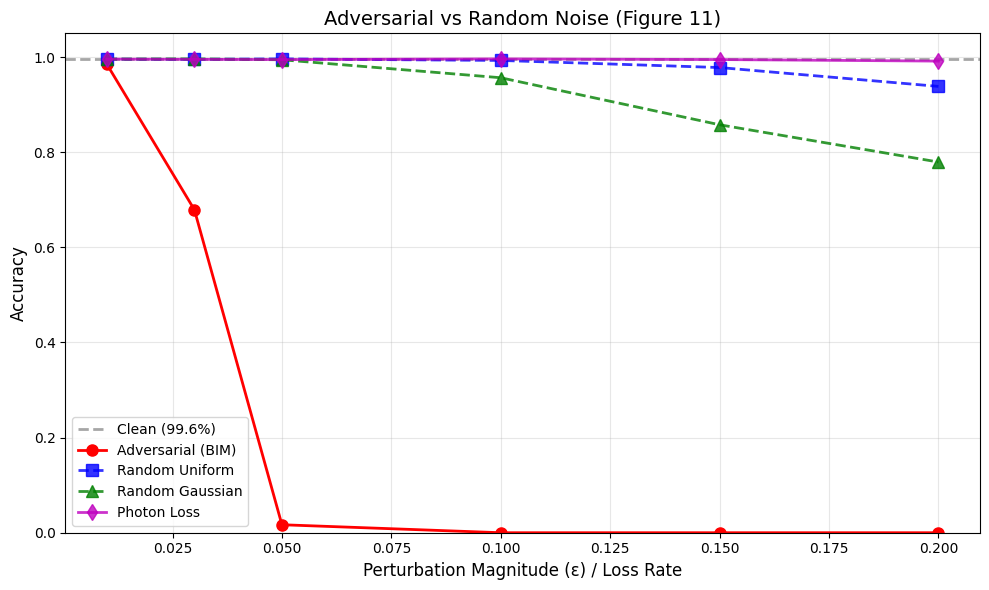

In [10]:
# Compare noise types
noise_results = compare_noise_vs_adversarial(
    model, test_loader,
    epsilon_values=[0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    attack_method="bim",
    num_iter=10,
    device=device
)

# Plot comparison
plot_noise_vs_adversarial(
    noise_results,
    title="Adversarial vs Random Noise (Figure 11)"
)
plt.show()

In [11]:
# Print summary table
print("="*70)
print("Noise vs Adversarial Comparison")
print("="*70)
print(f"{'Epsilon':<10} {'Adversarial':<15} {'Uniform':<15} {'Gaussian':<15} {'Photon Loss':<15}")
print("-"*70)

for i, eps in enumerate(noise_results['epsilon_values']):
    adv = noise_results['adversarial'][i]
    uni = noise_results['random_uniform'][i]
    gau = noise_results['random_gaussian'][i]
    pho = noise_results['photon_loss'][i]
    print(f"{eps:<10.2f} {adv:<15.1%} {uni:<15.1%} {gau:<15.1%} {pho:<15.1%}")

print("="*70)
print("\nKey insight: Adversarial perturbations cause much larger accuracy drops")
print("than random noise of the same magnitude!")

Noise vs Adversarial Comparison
Epsilon    Adversarial     Uniform         Gaussian        Photon Loss    
----------------------------------------------------------------------
0.01       98.5%           99.6%           99.6%           99.6%          
0.03       67.9%           99.5%           99.6%           99.5%          
0.05       1.7%            99.6%           99.4%           99.5%          
0.10       0.0%            99.3%           95.7%           99.6%          
0.15       0.0%            97.8%           85.8%           99.5%          
0.20       0.0%            93.8%           77.9%           99.2%          

Key insight: Adversarial perturbations cause much larger accuracy drops
than random noise of the same magnitude!


## 8. Extended: Amplitude vs Angle Encoding

This extends beyond the original paper to compare different quantum encoding schemes:

| Encoding | Method | Formula |
|----------|--------|--------|
| **Amplitude** | Data in state amplitudes | $\|\psi\rangle = \sum_i x_i \|i\rangle$ |
| **Angle** | Data in rotation angles | $x \rightarrow PS(\phi = x \cdot \text{scale})$ |

**Research Question:** Does the encoding method affect adversarial robustness?

In [12]:
# Angle encoding comparison - same quantum resources, different encoding
# Angle encoding: 256 → classical compression → 13 phase shifter angles
angle_model_config = {
    "type": "hybrid_angle",   # Angle encoding: x → PS(φ=x)
    "input_dim": 256,
    "n_outputs": 2,
    "hidden_dims": [128, 64], # Classical compression: 256→128→64→13
    "n_modes": 13,            # Same modes as amplitude for fair comparison
    "n_photons": 3,           # Same photons as amplitude
    "n_layers": 3,            # Sandwich layers
    "computation_space": "unbunched"
}
# Note: Angle encoding REQUIRES classical compression (256→13)
# because it can only encode n_modes values, not C(n_modes, n_photons).

angle_model = create_model(angle_model_config).to(device)
print(f"Angle Model: {angle_model.__class__.__name__}")

# Train
print("\nTraining angle-encoded classifier...")
angle_results = train_model(
    angle_model, train_loader, test_loader,
    training_config, device
)
print(f"Best accuracy: {angle_results['best_accuracy']:.1%}")

Angle Model: HybridQuantumClassifier

Training angle-encoded classifier...


Loss: 0.0077 | Train: 0.998 | Test: 0.998: 100%|██████████| 100/100 [48:27<00:00, 29.08s/it]

Best accuracy: 99.8%


Evaluating adversarial robustness...



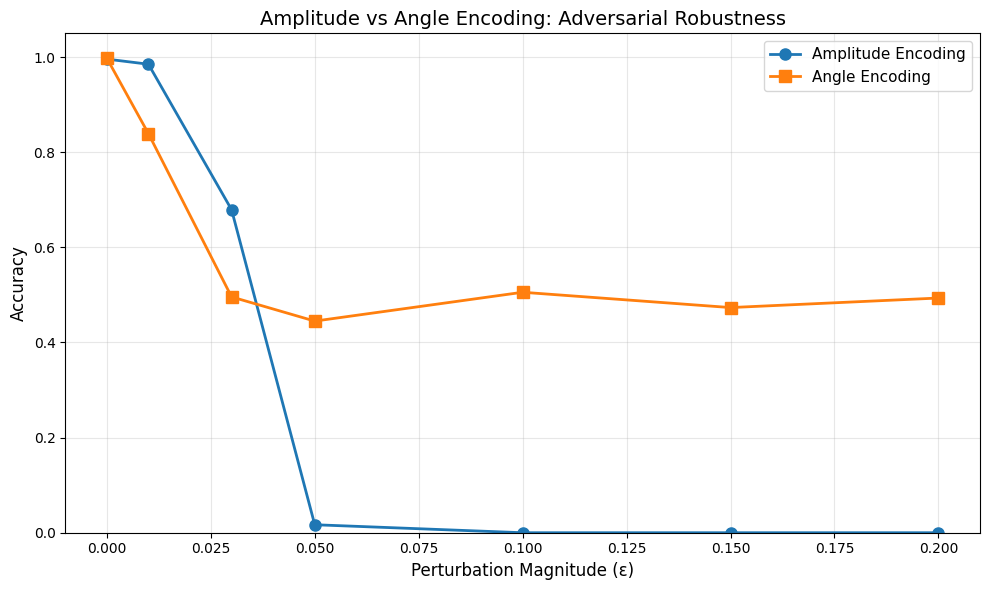


ENCODING COMPARISON
Epsilon    Amplitude       Angle           Difference     
------------------------------------------------------------
0.00       99.6%           99.8%           +0.2%
0.01       98.5%           83.9%           -14.6%
0.03       67.9%           49.6%           -18.3%
0.05       1.7%            44.5%           +42.8%
0.10       0.0%            50.6%           +50.6%
0.15       0.0%            47.3%           +47.3%
0.20       0.0%            49.3%           +49.3%


In [13]:
# Compare robustness of both encoding schemes
print("Evaluating adversarial robustness...\n")

# Amplitude encoding
amp_robust = evaluate_robustness(
    model, test_loader, ["bim"], epsilons, num_iter=10, device=device
)

# Angle encoding
angle_robust = evaluate_robustness(
    angle_model, test_loader, ["bim"], epsilons, num_iter=10, device=device
)

# Extract accuracies in order (evaluate_robustness returns {eps: acc} dict)
amp_accs = [amp_robust['bim'][eps] for eps in epsilons]
angle_accs = [angle_robust['bim'][eps] for eps in epsilons]

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(epsilons, amp_accs, 'o-', label='Amplitude Encoding', linewidth=2, markersize=8)
ax.plot(epsilons, angle_accs, 's-', label='Angle Encoding', linewidth=2, markersize=8)

ax.set_xlabel('Perturbation Magnitude (ε)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Amplitude vs Angle Encoding: Adversarial Robustness', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

# Print comparison
print("\n" + "="*60)
print("ENCODING COMPARISON")
print("="*60)
print(f"{'Epsilon':<10} {'Amplitude':<15} {'Angle':<15} {'Difference':<15}")
print("-"*60)
for i, eps in enumerate(epsilons):
    amp_acc = amp_accs[i]
    angle_acc = angle_accs[i]
    diff = angle_acc - amp_acc
    print(f"{eps:<10.2f} {amp_acc:<15.1%} {angle_acc:<15.1%} {diff:+.1%}")

## 9. Running Full Reproduction

To reproduce all figures from the paper, use the provided shell scripts:

```bash
# Full reproduction (takes ~30 minutes)
./scripts/reproduce_all.sh

# Individual experiments:
./scripts/train_classifiers.sh      # Figures 4-5: Training curves
./scripts/figure7_robustness.sh     # Figure 7: Robustness sweep
./scripts/figure11_noise_comparison.sh  # Figure 11: Noise comparison
./scripts/table3_transfer.sh        # Table III: Transfer attacks
./scripts/figure16_defense.sh       # Figure 16: Adversarial training
./scripts/topological_phases.sh     # Section III.C: Topological phases
./scripts/encoding_comparison.sh    # Extended: Amplitude vs Angle
```

Results are saved in `outdir/`.

## 10. Configuration Files

Experiments are configured via JSON files in `configs/`:

```python
# Example: configs/train_quantum.json
{
  "experiment": "mnist",
  "dataset": {
    "digits": [1, 9],
    "image_size": 16
  },
  "model": {
    "type": "amplitude_quantum",
    "n_modes": 13,
    "n_photons": 3,
    "n_layers": 2
  },
  "training": {
    "epochs": 100,
    "learning_rate": 0.005
  }
}
```

Run with:
```bash
python implementation.py --paper quantum_adversarial_ml \
    --config configs/train_quantum.json \
    --outdir outdir/my_experiment
```

## 11. Summary

### Key Takeaways from the Paper

1. **Quantum ML is vulnerable** to adversarial attacks, just like classical ML
2. **Adversarial perturbations >> Random noise** in effectiveness
3. **Black-box attacks work** via transfer from classical surrogates
4. **Adversarial training helps** but doesn't fully solve the problem

### This Implementation

- Uses **MerLin** (Quandela) for photonic quantum circuits
- Supports **amplitude encoding** (paper's approach) and **angle encoding** (alternative)
- Includes **photon loss** as quantum-native noise for comparison
- Provides **shell scripts** to reproduce all paper figures

### Extensions

- Amplitude vs Angle encoding comparison
- Photon loss noise (photonic-specific)
- Functional attacks using phase shifter perturbations

---

## References

1. Lu, S., Duan, L. M., & Deng, D. L. (2020). Quantum adversarial machine learning. *Physical Review Research*, 2(3), 033212.

2. Goodfellow, I. J., Shlens, J., & Szegedy, C. (2014). Explaining and harnessing adversarial examples. *arXiv preprint arXiv:1412.6572*.

3. Kurakin, A., Goodfellow, I., & Bengio, S. (2016). Adversarial examples in the physical world. *arXiv preprint arXiv:1607.02533*.

4. MerLin Documentation: https://perceval.quandela.net/